In [30]:
!pip install dlib


In [31]:
import dlib

predictor_path = '/content/drive/MyDrive/IBM/shape_predictor_81_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)


In [45]:
import cv2

image_path = '/content/drive/MyDrive/IBM/messi.jpg'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = dlib.get_frontal_face_detector()(gray)
for face in faces:
    landmarks = predictor(gray, face)
    for i in range(49, 69):# Lip landmarks in the 81-point model
      x, y = landmarks.part(i).x, landmarks.part(i).y
      cv2.circle(image, (x, y), 2, (0, 255, 0), -1)



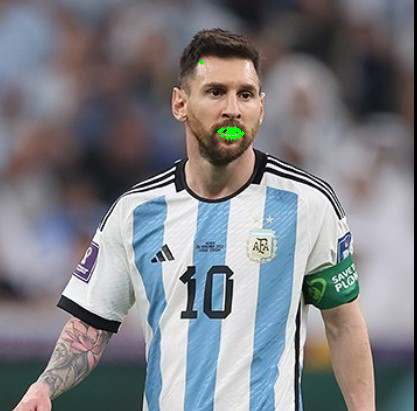

In [46]:
import cv2
from google.colab.patches import cv2_imshow

# Load the image and perform facial landmark detection as before

# Display the image with landmarks
cv2_imshow(image)


# Tracking Lip LamdMarks From a Video With tha Lable "pleased"

In [108]:
import dlib
import cv2
from google.colab.patches import cv2_imshow

# Load the pre-trained model
predictor_path = '/content/drive/MyDrive/IBM/shape_predictor_81_face_landmarks.dat'  # Adjust the path
predictor = dlib.shape_predictor(predictor_path)

# Open video capture
video_path = '/content/drive/MyDrive/IBM/pleased.mp4'  # Adjust the path
cap = cv2.VideoCapture(video_path)


In [109]:
import numpy as np
i=0
frame=0
j=0
k=0
lip_landmarks = []
lip_49 = []
# print("hhh")
while cap.isOpened():
    i+=1
    ret, frame = cap.read()
    # print("hi")
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = dlib.get_frontal_face_detector()(gray)

    for face in faces:
        landmarks = predictor(gray, face)
        reference_point = np.array([landmarks.part(48).x, landmarks.part(48).y])  # Point 49 (0-based index)
        # print("hello")
        j+=1
        for i in range(49, 68):
            x, y = landmarks.part(i).x, landmarks.part(i).y
            normalized_x = x - reference_point[0]
            normalized_y = y - reference_point[1]
            # print(normalized_x)
            lip_landmarks.append((normalized_x, normalized_y))
            k+=1



        # Draw circles on the lip landmarks
    #     for x, y in lip_landmarks:
    #         cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)

    # cv2_imshow(frame)

cap.release()
cv2.destroyAllWindows()


In [111]:
frame,i,j,k

(None, 68, 59, 1121)

In [113]:
import cv2

# Open video capture
video_path = '/content/drive/MyDrive/IBM/pleased.mp4'

cap = cv2.VideoCapture(video_path)

# Get the total number of frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Total Number of Frames: {total_frames}")

cap.release()


Total Number of Frames: 59


In [114]:
type(lip_landmarks)

list

# Turning the list into a Tensor

In [116]:
import torch
tensor1=torch.FloatTensor(lip_landmarks)
type(tensor1)

torch.Tensor

In [119]:
tensor1.size()

torch.Size([1121, 2])

# Resizing the tensor from [19,59,2] to [2,19,59]
 Where 19 is the NO Of landmarks of lips and 59 is total number of frames present in the video and 2 is the x and y coordinates of the land mark points

In [125]:
reshaped_tensor = tensor1.view(19,59,2)
reshaped_tensor=reshaped_tensor.permute(2, 0, 1)
reshaped_tensor.size()

torch.Size([2, 19, 59])

# CLASSIFIER
  It is used to map the movement of the lips to the corrsponding word

In [126]:
import torch.nn as nn
class Classifier(nn.Module):

  def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 9 * 29, 256)
        self.fc2 = nn.Linear(256, 10)  # Output size set to 10

  def forward(self, x):
      x = self.pool(self.relu(self.conv1(x)))
      x = x.view(-1, 16 * 9 * 29)
      x = self.relu(self.fc1(x))
      x = self.fc2(x)
      return x


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
model = Classifier()
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()  # Set model to training mode
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item()}")

# Testing loop
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")